In [2]:
from sklearn.linear_model import LinearRegression
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


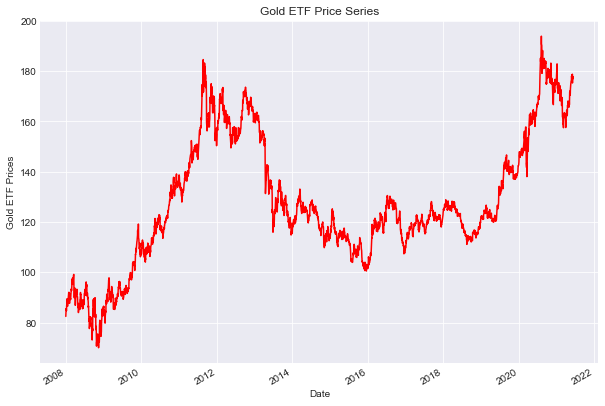

In [3]:
Df = yf.download('GLD', '2008-01-01', '2021-6-10', auto_adjust=True)
Df = Df[['Close']]
Df = Df.dropna()
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

In [4]:
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)
Df = Df.dropna()
X = Df[['S_3', 'S_9']]
y = Df['next_day_price']
print(Df)

                 Close         S_3         S_9  next_day_price
Date                                                          
2008-01-11   88.580002   87.793335   85.883333       89.540001
2008-01-14   89.540001   88.790001   86.670000       87.989998
2008-01-15   87.989998   88.703334   87.017777       86.699997
2008-01-16   86.699997   88.076665   87.143333       86.500000
2008-01-17   86.500000   87.063332   87.295555       87.419998
...                ...         ...         ...             ...
2021-06-02  178.770004  178.350001  177.411112      175.270004
2021-06-03  175.270004  177.313334  177.334446      177.160004
2021-06-04  177.160004  177.066671  177.458891      177.869995
2021-06-07  177.869995  176.766668  177.627779      177.320007
2021-06-08  177.320007  177.450002  177.557780      176.979996

[3375 rows x 4 columns]


In [5]:
t = .8
t = int(t*len(Df))

X_train = X[:t]
y_train = y[:t]

X_test = X[t:]
y_test = y[t:]

#print(X_train,X_test,y_train,y_test)

In [6]:
linear = LinearRegression().fit(X_train,y_train)

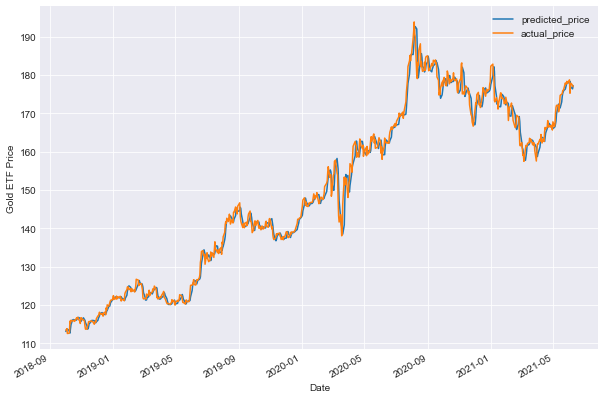

In [7]:
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

In [8]:
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

99.2

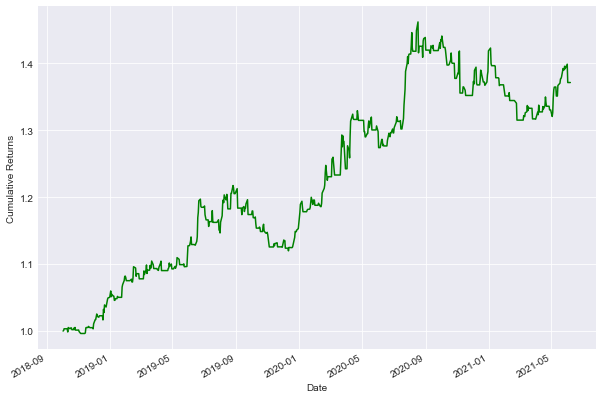

In [9]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [10]:
sharpe = gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 1.14'

In [11]:
import datetime as dt
current_date = dt.datetime.now()

# Get the data
data = yf.download('GLD', '2008-06-01', current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()

# Forecast the price
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")

# Print the forecast
data.tail(1)[['signal','predicted_gold_price']].T

[*********************100%***********************]  1 of 1 completed
<ipython-input-11-37aad7a54fe5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
<ipython-input-11-37aad7a54fe5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")


Date,2021-06-11
signal,No Position
predicted_gold_price,176.570201
